### Gated RNNs

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras import regularizers
from keras.metrics import RootMeanSquaredError
from keras import backend as K

In [28]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def make_gated_RNN_model(training_seqs, layer_obj, network_size, num_layers, learning_rate, dropout, L2_reg):
    model = Sequential()
    if num_layers > 1:
        model.add(
            layer_obj(
                int(network_size/num_layers),
                dropout=dropout,
                return_sequences=True,
                kernel_regularizer=regularizers.l2(L2_reg),
                input_shape=(training_seqs.shape[1], training_seqs.shape[2])
            )
        )
    else:
        model.add(
            layer_obj(
                int(network_size/num_layers),
                dropout=dropout,
                kernel_regularizer=regularizers.l2(L2_reg),
                input_shape=(training_seqs.shape[1], training_seqs.shape[2])
            )
        )
    for i in range(1,num_layers):
        if i < num_layers - 1:
            model.add(
                layer_obj(
                    int(network_size/num_layers),
                    dropout=dropout,
                    return_sequences=True,
                    kernel_regularizer=regularizers.l2(L2_reg)
                )
            )
        else:
            model.add(
                layer_obj(
                    int(network_size/num_layers),
                    dropout=dropout,
                    kernel_regularizer=regularizers.l2(L2_reg)
                )
            )
    model.add(layers.Dense(training_seqs.shape[2]))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=root_mean_squared_error)
    return model

def RMSE(prediction, target):
    n = len(prediction)
    return np.linalg.norm(prediction - target)/np.sqrt(n)

def recursive_prediction(model, data, seq_len, t_forward, quiet=True):
    running_data = data
    recursive_out = []
    for i in range(t_forward):
        if i%100 == 0 and quiet==False:
            print(i)
        seq = running_data[-seq_len:]
        y = model.predict(np.array([seq]),verbose=0)
        running_data = np.vstack((running_data, y))
        recursive_out.append(y[0])
    recursive_out = np.array(recursive_out)
    return recursive_out

In [29]:
mg = pd.read_json("mackey-glass.json").to_numpy()
lorenz = pd.read_json("lorenz.json").to_numpy()
lorenz_scaled = pd.read_json("lorenz-scaled.json").to_numpy()

In [30]:
# model hyperparameter grid
num_layers_arr = [1, 2, 4]
learning_rate_arr = [0.001, 0.002, 0.005, 0.010, 0.050, 0.100]
dropout_arr = [0.00, 0.05, 0.10, 0.20, 0.50]
epochs_arr = [5, 10, 15, 20, 30, 50, 100]
L2_reg_arr = [1e-6, 1e-5, 1e-4, 1e-3, 0]

# defaults for simple (independent) grid search
network_size = 100 # (this is not varied)
num_layers = 1
learning_rate = 0.01
dropout = 0.00
epochs = 10
L2_reg = 1e-4

In [97]:
params_arr = [
    num_layers_arr,
    learning_rate_arr,
    dropout_arr,
    epochs_arr,
    L2_reg_arr
]

In [91]:
split_indices = []
cnt = 0
for x in [
    num_layers_arr,
    learning_rate_arr,
    dropout_arr,
    epochs_arr
]:
    cnt += len(x)
    split_indices.append(cnt)
split_indices

[3, 9, 14, 21]

In [112]:
def get_best_params(split_results_arr, params_arr):
    param_indices = [np.argmin(x) for x in split_results_arr]
    params = [params_arr[i][param_indices[i]] for i in range(len(param_indices))]
    return params

#### Mackey-Glass

15000 total, 1,000 pre-train, 11,000 training, 3,000 testing

In [171]:
data = mg[:,1:]
targets = mg[1:,1:]

In [172]:
length = 100
training_start = 1000
training_end = 12000
test_start = training_end
test_end = 15000

seqs =[]
target = []
for i in range(training_start, test_end):
    subseq = []
    for j in range(length):
        subseq.append(data[i-length+j])
    seqs.append(subseq)
    target.append(targets[i-1])
seqs = np.array(seqs)
target = np.array(target)

training_seqs = seqs[:training_end-training_start]
training_target = target[:training_end-training_start]
test_seqs = seqs[training_end-training_start:test_end-training_start]
test_target = target[training_end-training_start:test_end-training_start]

seqs.shape, target.shape, training_seqs.shape, training_target.shape, test_seqs.shape, test_target.shape

((14000, 100, 1),
 (14000, 1),
 (11000, 100, 1),
 (11000, 1),
 (3000, 100, 1),
 (3000, 1))

In [ ]:
lstm_model_arr = []
for x in num_layers_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=x,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)
for x in learning_rate_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=x,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)
for x in dropout_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=x,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)
for x in epochs_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=x
    )
    lstm_model_arr.append(model)
for x in L2_reg_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=x
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)

Epoch 1/10
344/344 [==============================] - 12s 33ms/step - loss: 0.0392
Epoch 2/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0234
Epoch 3/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0126
Epoch 4/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0130
Epoch 5/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0105
Epoch 6/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0087
Epoch 7/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0118
Epoch 8/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0101
Epoch 9/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0098
Epoch 10/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0081
Epoch 1/10
344/344 [==============================] - 13s 34ms/step - loss: 0.0573
Epoch 2/10
344/344 [==============================] - 12s 35ms/step - loss: 0.0301
Epo

In [38]:
eval_arr = []
for x in lstm_model_arr:
    err = x.evaluate(test_seqs, test_target)
    eval_arr.append(err)

94/94 [==============================] - 1s 9ms/step - loss: 0.0088


In [40]:
recursive_rmse_arr = []
cnt = 0
for x in lstm_model_arr:
    out = recursive_prediction(model=x, data=data[training_start:training_end], seq_len=seqs.shape[1], t_forward=test_end-test_start, quiet=True)
    err = RMSE(out, test_target)
    recursive_rmse_arr.append(err)
    cnt += 1
    print(f'done: {cnt}')
recursive_rmse_arr = np.array(recursive_rmse_arr)

done: 1
done: 2
done: 3
done: 4
done: 5
done: 6
done: 7
done: 8
done: 9
done: 10
done: 11
done: 12
done: 13
done: 14
done: 15
done: 16
done: 17
done: 18
done: 19
done: 20
done: 21
done: 22
done: 23
done: 24
done: 25
done: 26


In [ ]:
mg_lstm_eval_arr = eval_arr
mg_lstm_model_arr = lstm_model_arr
mg_lstm_recursive_rmse_arr = recursive_rmse_arr

In [122]:
mg_lstm_eval_split = np.split(mg_lstm_eval_arr.copy(), split_indices)
mg_lstm_recursive_split = np.split(mg_lstm_recursive_rmse_arr.copy(), split_indices)

In [123]:
mg_lstm_eval_params = get_best_params(mg_lstm_eval_split, params_arr)
mg_lstm_recursive_params = get_best_params(mg_lstm_recursive_split, params_arr)
mg_lstm_eval_params, mg_lstm_recursive_params

([2, 0.002, 0.0, 50, 1e-05], [4, 0.005, 0.05, 10, 1e-05])

In [124]:
mg_lstm_eval_model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=mg_lstm_eval_params[0],
        learning_rate=mg_lstm_eval_params[1],
        dropout=mg_lstm_eval_params[2],
        L2_reg=mg_lstm_eval_params[4]
    )
mg_lstm_eval_model.fit(
        training_seqs,
        training_target,
        epochs=mg_lstm_eval_params[3]
    )
mg_lstm_recursive_model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=mg_lstm_recursive_params[0],
        learning_rate=mg_lstm_recursive_params[1],
        dropout=mg_lstm_recursive_params[2],
        L2_reg=mg_lstm_recursive_params[4]
    )
mg_lstm_recursive_model.fit(
        training_seqs,
        training_target,
        epochs=mg_lstm_recursive_params[3]
    )

Epoch 1/50
344/344 [==============================] - 13s 33ms/step - loss: 0.0714
Epoch 2/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0198
Epoch 3/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0128
Epoch 4/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0103
Epoch 5/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0095
Epoch 6/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0088
Epoch 7/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0093
Epoch 8/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0085
Epoch 9/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0079
Epoch 10/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0075
Epoch 11/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0063
Epoch 12/50
344/344 [==============================] - 12s 34ms/step - loss: 0.0078
E

In [126]:
test_out = mg_lstm_eval_model.predict(test_seqs)

94/94 [==============================] - 1s 9ms/step


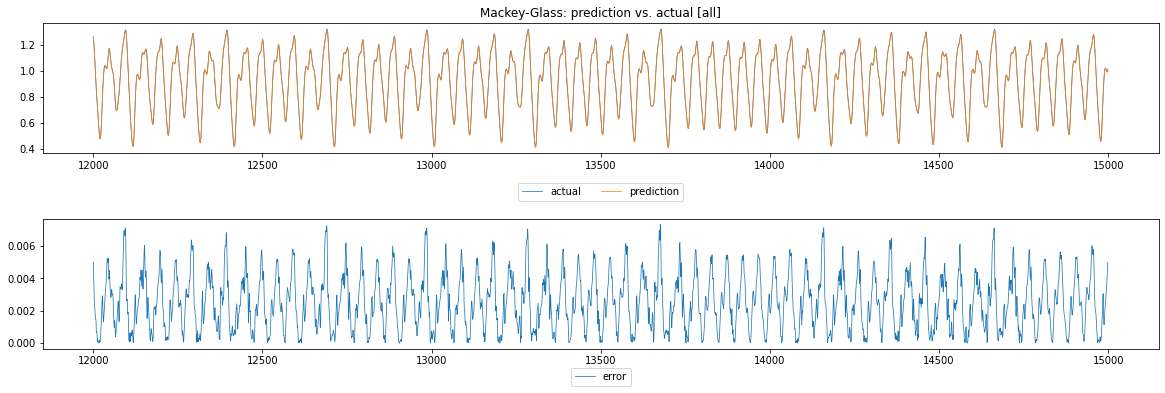

In [138]:
fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], linewidth=0.75, label="actual")
axs[0].plot(np.arange(test_start,test_end), test_out[:,0], linewidth=0.75, label="prediction")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,0]-test_target[:,0]), linewidth=0.75, label="error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title('Mackey-Glass: prediction vs. actual [all]')
plt.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig(f'mackey-glass-one-step_lstm_eval.png',facecolor='white', transparent=False)

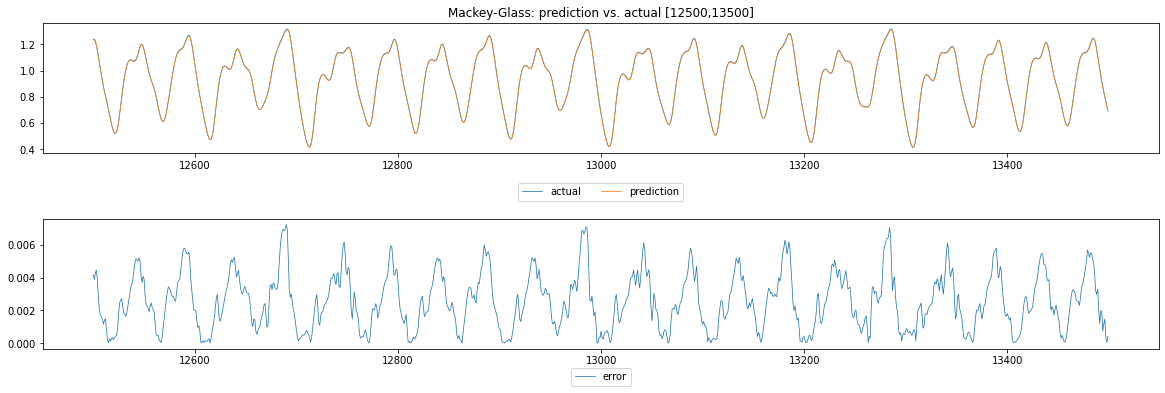

In [139]:
start = 12500
pts_to_show = 1000
fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="prediction")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,0]-test_target[start-test_start:start-test_start+pts_to_show,0]), linewidth=0.75, label="error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title(f'Mackey-Glass: prediction vs. actual [{start},{start+pts_to_show}]')
plt.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig(f'mackey-glass-one-step_lstm_eval_[{start},{start+pts_to_show}].png',facecolor='white', transparent=False)

Recursive Prediction

In [129]:
recursive_out = recursive_prediction(model=mg_lstm_eval_model, data=data[training_start:training_end], seq_len=seqs.shape[1], t_forward=test_end-test_start, quiet=True)

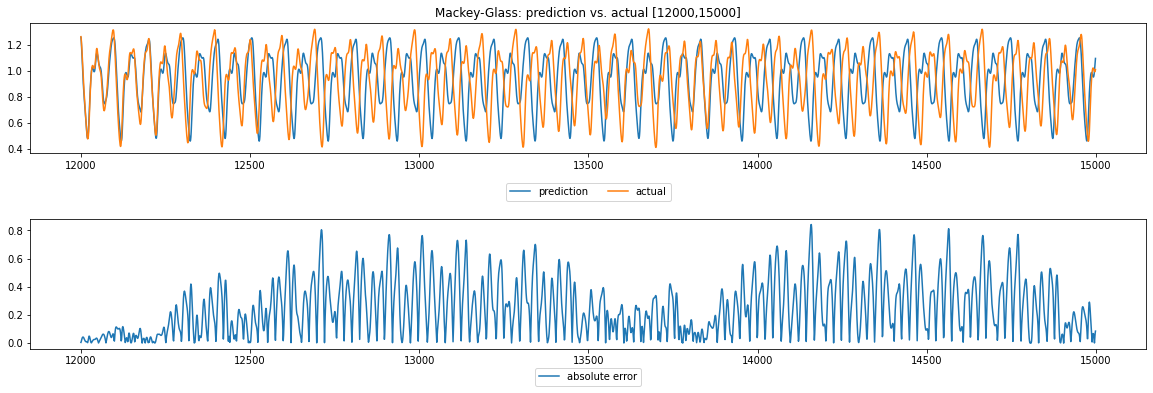

In [145]:
fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(test_start,test_end), recursive_out[:,0], label="prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], label="actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out[:,0]-test_target[:,0]), label="absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title(f'Mackey-Glass: prediction vs. actual [{test_start},{test_end}]')
plt.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig(f'mackey-glass-recursive_eval_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

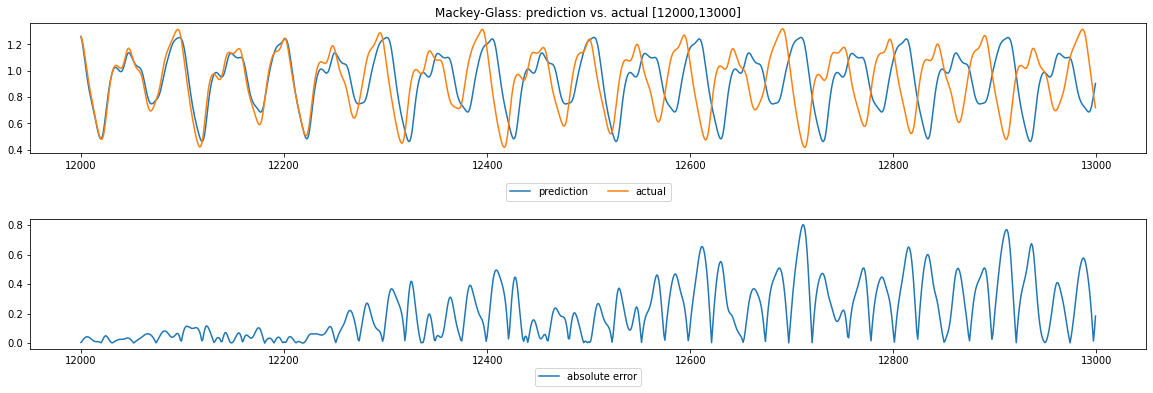

In [146]:
start = 12000
pts_to_show = 1000
fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(start,start+pts_to_show), recursive_out[start-test_start:start-test_start+pts_to_show,0], label="prediction")
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,0], label="actual")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(recursive_out[start-test_start:start-test_start+pts_to_show,0]-test_target[start-test_start:start-test_start+pts_to_show,0]), label="absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title(f'Mackey-Glass: prediction vs. actual [{start},{start+pts_to_show}]')
plt.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig(f'mackey-glass-recursive_eval_lstm_[{start},{start+pts_to_show}].png',facecolor='white', transparent=False)

In [133]:
recursive_out_2 = recursive_prediction(model=mg_lstm_recursive_model, data=data[training_start:training_end], seq_len=seqs.shape[1], t_forward=test_end-test_start, quiet=True)

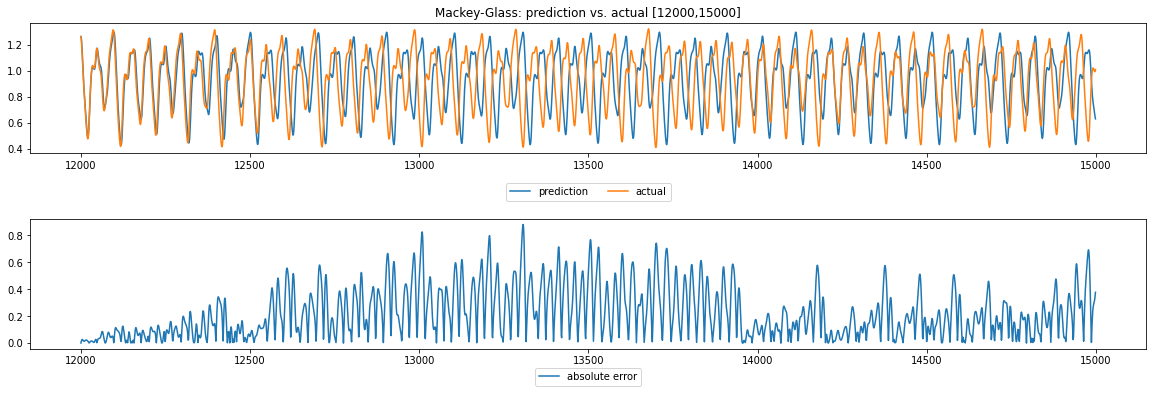

In [143]:
fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(test_start,test_end), recursive_out_2[:,0], label="prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], label="actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out_2[:,0]-test_target[:,0]), label="absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title(f'Mackey-Glass: prediction vs. actual [{test_start},{test_end}]')
plt.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig(f'mackey-glass-recursive_rec_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

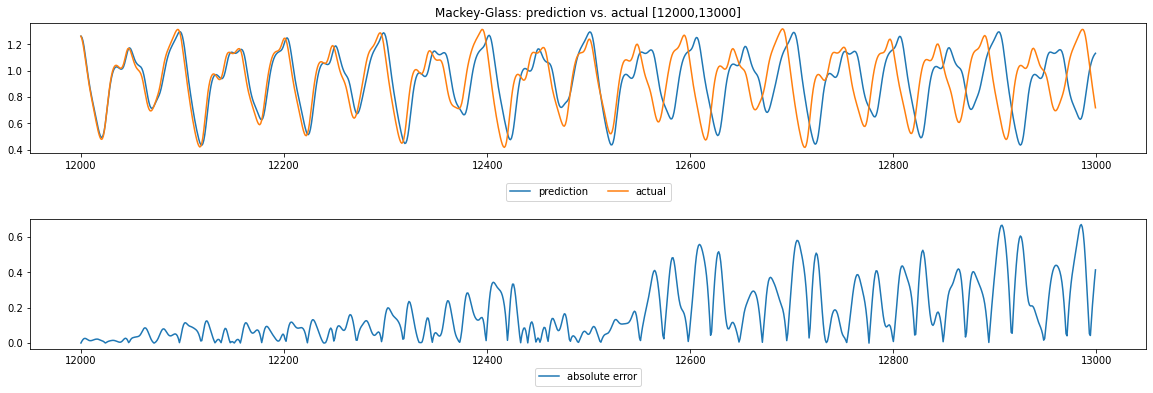

In [144]:
start = 12000
pts_to_show = 1000
fig, axs = plt.subplots(2, figsize=(20, 6))
axs[0].plot(np.arange(start,start+pts_to_show), recursive_out_2[start-test_start:start-test_start+pts_to_show,0], label="prediction")
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,0], label="actual")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(recursive_out_2[start-test_start:start-test_start+pts_to_show,0]-test_target[start-test_start:start-test_start+pts_to_show,0]), label="absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.4))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.32))
axs[0].set_title(f'Mackey-Glass: prediction vs. actual [{start},{start+pts_to_show}]')
plt.subplots_adjust(hspace=0.5)
plt.show()
fig.savefig(f'mackey-glass-recursive_rec_lstm_[{start},{start+pts_to_show}].png',facecolor='white', transparent=False)

In [173]:
# one-step model
mg_lstm_eval_model.evaluate(test_seqs, test_target)

94/94 [==============================] - 1s 9ms/step - loss: 0.0032


0.0032249712385237217

In [137]:
RMSE(recursive_out, test_target)

0.3199208687141725

In [174]:
# recursive model
mg_lstm_recursive_model.evaluate(test_seqs, test_target)

94/94 [==============================] - 2s 11ms/step - loss: 0.0175


0.017544396221637726

In [136]:
RMSE(recursive_out_2, test_target)

0.28740111468707397

In [ ]:
for i in range(len(mg_lstm_model_arr)):
    model = mg_lstm_model_arr[i]
    model.save(f'mg-lstm-model-{i}')

INFO:tensorflow:Assets written to: mg-lstm-model-0/assets


INFO:tensorflow:Assets written to: mg-lstm-model-0/assets


INFO:tensorflow:Assets written to: mg-lstm-model-1/assets


INFO:tensorflow:Assets written to: mg-lstm-model-1/assets


INFO:tensorflow:Assets written to: mg-lstm-model-2/assets


INFO:tensorflow:Assets written to: mg-lstm-model-2/assets


INFO:tensorflow:Assets written to: mg-lstm-model-3/assets


INFO:tensorflow:Assets written to: mg-lstm-model-3/assets


INFO:tensorflow:Assets written to: mg-lstm-model-4/assets


INFO:tensorflow:Assets written to: mg-lstm-model-4/assets


INFO:tensorflow:Assets written to: mg-lstm-model-5/assets


INFO:tensorflow:Assets written to: mg-lstm-model-5/assets


INFO:tensorflow:Assets written to: mg-lstm-model-6/assets


INFO:tensorflow:Assets written to: mg-lstm-model-6/assets


INFO:tensorflow:Assets written to: mg-lstm-model-7/assets


INFO:tensorflow:Assets written to: mg-lstm-model-7/assets


INFO:tensorflow:Assets written to: mg-lstm-model-8/assets


INFO:tensorflow:Assets written to: mg-lstm-model-8/assets


INFO:tensorflow:Assets written to: mg-lstm-model-9/assets


INFO:tensorflow:Assets written to: mg-lstm-model-9/assets


INFO:tensorflow:Assets written to: mg-lstm-model-10/assets


INFO:tensorflow:Assets written to: mg-lstm-model-10/assets


INFO:tensorflow:Assets written to: mg-lstm-model-11/assets


INFO:tensorflow:Assets written to: mg-lstm-model-11/assets


INFO:tensorflow:Assets written to: mg-lstm-model-12/assets


INFO:tensorflow:Assets written to: mg-lstm-model-12/assets


INFO:tensorflow:Assets written to: mg-lstm-model-13/assets


INFO:tensorflow:Assets written to: mg-lstm-model-13/assets


INFO:tensorflow:Assets written to: mg-lstm-model-14/assets


INFO:tensorflow:Assets written to: mg-lstm-model-14/assets


INFO:tensorflow:Assets written to: mg-lstm-model-15/assets


INFO:tensorflow:Assets written to: mg-lstm-model-15/assets


INFO:tensorflow:Assets written to: mg-lstm-model-16/assets


INFO:tensorflow:Assets written to: mg-lstm-model-16/assets


INFO:tensorflow:Assets written to: mg-lstm-model-17/assets


INFO:tensorflow:Assets written to: mg-lstm-model-17/assets


INFO:tensorflow:Assets written to: mg-lstm-model-18/assets


INFO:tensorflow:Assets written to: mg-lstm-model-18/assets


INFO:tensorflow:Assets written to: mg-lstm-model-19/assets


INFO:tensorflow:Assets written to: mg-lstm-model-19/assets


INFO:tensorflow:Assets written to: mg-lstm-model-20/assets


INFO:tensorflow:Assets written to: mg-lstm-model-20/assets


INFO:tensorflow:Assets written to: mg-lstm-model-21/assets


INFO:tensorflow:Assets written to: mg-lstm-model-21/assets


INFO:tensorflow:Assets written to: mg-lstm-model-22/assets


INFO:tensorflow:Assets written to: mg-lstm-model-22/assets


INFO:tensorflow:Assets written to: mg-lstm-model-23/assets


INFO:tensorflow:Assets written to: mg-lstm-model-23/assets


INFO:tensorflow:Assets written to: mg-lstm-model-24/assets


INFO:tensorflow:Assets written to: mg-lstm-model-24/assets


INFO:tensorflow:Assets written to: mg-lstm-model-25/assets


INFO:tensorflow:Assets written to: mg-lstm-model-25/assets


GRU

In [77]:
gru_model_arr = []
for x in num_layers_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.GRU,
        network_size=network_size,
        num_layers=x,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    gru_model_arr.append(model)
for x in learning_rate_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.GRU,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=x,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    gru_model_arr.append(model)
for x in dropout_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.GRU,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=x,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    gru_model_arr.append(model)
for x in epochs_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.GRU,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=x
    )
    gru_model_arr.append(model)
for x in L2_reg_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.GRU,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=x
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    gru_model_arr.append(model)

Epoch 1/10
344/344 [==============================] - 12s 32ms/step - loss: 0.0315
Epoch 2/10
344/344 [==============================] - 11s 32ms/step - loss: 0.0187
Epoch 3/10
344/344 [==============================] - 11s 33ms/step - loss: 0.1069
Epoch 4/10
344/344 [==============================] - 11s 33ms/step - loss: 0.0696
Epoch 5/10
344/344 [==============================] - 11s 31ms/step - loss: 0.0431
Epoch 6/10
344/344 [==============================] - 10s 30ms/step - loss: 0.0459
Epoch 7/10
344/344 [==============================] - 11s 31ms/step - loss: 0.0480
Epoch 8/10
344/344 [==============================] - 11s 31ms/step - loss: 0.0474
Epoch 9/10
344/344 [==============================] - 11s 31ms/step - loss: 0.0663
Epoch 10/10
344/344 [==============================] - 11s 31ms/step - loss: 0.0551
Epoch 1/10
344/344 [==============================] - 13s 34ms/step - loss: 0.0572
Epoch 2/10
344/344 [==============================] - 12s 34ms/step - loss: 0.0249
Epo

In [78]:
mg_gru_model_arr = gru_model_arr

In [ ]:
len(mg_gru_model_arr)

#### Lorenz

10000 total,   500 pre-train,  7,500 training, 2,000 testing

In [175]:
# data = lorenz[:,1:]
# targets = lorenz[1:,1:]
data = lorenz_scaled[:,1:]
targets = lorenz_scaled[1:,1:]

In [176]:
length = 100
training_start = 500
training_end = 8000
test_start = training_end
test_end = 10000

seqs =[]
target = []
for i in range(training_start, test_end):
    subseq = []
    for j in range(length):
        subseq.append(data[i-length+j])
    seqs.append(subseq)
    target.append(targets[i-1])
seqs = np.array(seqs)
target = np.array(target)

training_seqs = seqs[:training_end-training_start]
training_target = target[:training_end-training_start]
test_seqs = seqs[training_end-training_start:test_end-training_start]
test_target = target[training_end-training_start:test_end-training_start]

seqs.shape, target.shape, training_seqs.shape, training_target.shape, test_seqs.shape, test_target.shape

((9500, 100, 3),
 (9500, 3),
 (7500, 100, 3),
 (7500, 3),
 (2000, 100, 3),
 (2000, 3))

In [62]:
lstm_model_arr = []
for x in num_layers_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=x,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)
for x in learning_rate_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=x,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)
for x in dropout_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=x,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)
for x in epochs_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=L2_reg
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=x
    )
    lstm_model_arr.append(model)
for x in L2_reg_arr:
    model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=num_layers,
        learning_rate=learning_rate,
        dropout=dropout,
        L2_reg=x
    )
    model.fit(
        training_seqs,
        training_target,
        epochs=epochs
    )
    lstm_model_arr.append(model)

Epoch 1/10
235/235 [==============================] - 8s 33ms/step - loss: 0.0255
Epoch 2/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0099
Epoch 3/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0085
Epoch 4/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0074
Epoch 5/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0074
Epoch 6/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0067
Epoch 7/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0065
Epoch 8/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0058
Epoch 9/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0063
Epoch 10/10
235/235 [==============================] - 8s 34ms/step - loss: 0.0057
Epoch 1/10
235/235 [==============================] - 12s 36ms/step - loss: 0.0353
Epoch 2/10
235/235 [==============================] - 8s 36ms/step - loss: 0.0157
Epoch 3/10
235

In [63]:
eval_arr = []
for x in lstm_model_arr:
    err = x.evaluate(test_seqs, test_target)
    eval_arr.append(err)

63/63 [==============================] - 1s 10ms/step - loss: 0.0027


In [64]:
recursive_rmse_arr = []
cnt = 0
for x in lstm_model_arr:
    out = recursive_prediction(model=x, data=data[training_start:training_end], seq_len=seqs.shape[1], t_forward=test_end-test_start, quiet=True)
    err = RMSE(out, test_target)
    recursive_rmse_arr.append(err)
    cnt += 1
    print(f'done: {cnt}')
recursive_rmse_arr = np.array(recursive_rmse_arr)

done: 1
done: 2
done: 3
done: 4
done: 5
done: 6
done: 7
done: 8
done: 9
done: 10
done: 11
done: 12
done: 13
done: 14
done: 15
done: 16
done: 17
done: 18
done: 19
done: 20
done: 21
done: 22
done: 23
done: 24
done: 25
done: 26


In [ ]:
lor_lstm_eval_arr = eval_arr
lor_lstm_model_arr = lstm_model_arr
lor_lstm_recursive_rmse_arr = recursive_rmse_arr

In [149]:
lor_lstm_eval_split = np.split(lor_lstm_eval_arr.copy(), split_indices)
lor_lstm_recursive_split = np.split(lor_lstm_recursive_rmse_arr.copy(), split_indices)

In [150]:
lor_lstm_eval_params = get_best_params(lor_lstm_eval_split, params_arr)
lor_lstm_recursive_params = get_best_params(lor_lstm_recursive_split, params_arr)
lor_lstm_eval_params, lor_lstm_recursive_params

([1, 0.001, 0.0, 100, 0], [1, 0.005, 0.1, 30, 0])

In [151]:
lor_lstm_eval_model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=lor_lstm_eval_params[0],
        learning_rate=lor_lstm_eval_params[1],
        dropout=lor_lstm_eval_params[2],
        L2_reg=lor_lstm_eval_params[4]
    )
lor_lstm_eval_model.fit(
        training_seqs,
        training_target,
        epochs=lor_lstm_eval_params[3]
    )
lor_lstm_recursive_model = make_gated_RNN_model(
        training_seqs,
        layer_obj=layers.LSTM,
        network_size=network_size,
        num_layers=lor_lstm_recursive_params[0],
        learning_rate=lor_lstm_recursive_params[1],
        dropout=lor_lstm_recursive_params[2],
        L2_reg=lor_lstm_recursive_params[4]
    )
lor_lstm_recursive_model.fit(
        training_seqs,
        training_target,
        epochs=lor_lstm_recursive_params[3]
    )

Epoch 1/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0423
Epoch 2/100
235/235 [==============================] - 7s 32ms/step - loss: 0.0048
Epoch 3/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0038
Epoch 4/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0037
Epoch 5/100
235/235 [==============================] - 8s 33ms/step - loss: 0.0035
Epoch 6/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0032
Epoch 7/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0030
Epoch 8/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0029
Epoch 9/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0026
Epoch 10/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0024
Epoch 11/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0029
Epoch 12/100
235/235 [==============================] - 8s 32ms/step - loss: 0.0026
E

In [152]:
test_out = lor_lstm_eval_model.predict(test_seqs)

63/63 [==============================] - 1s 10ms/step


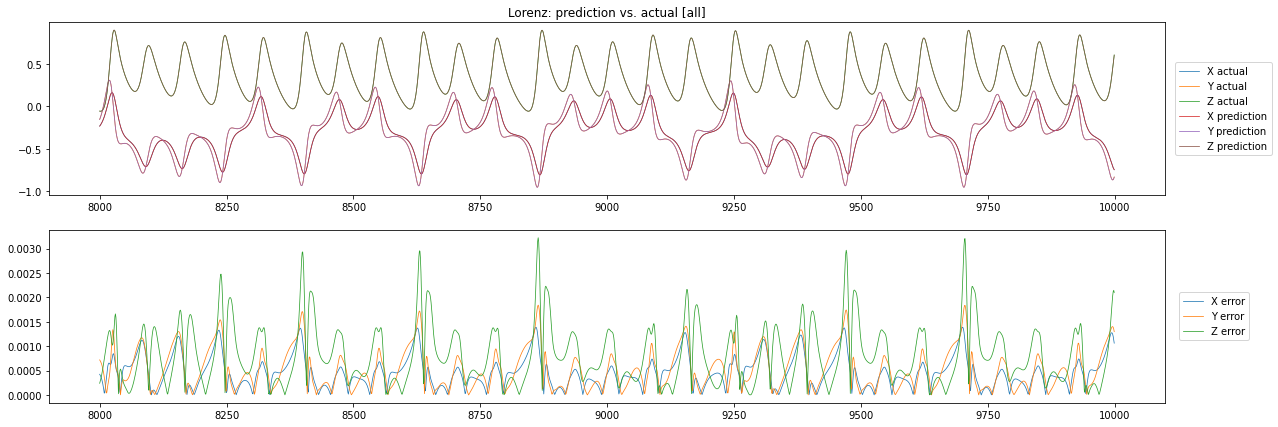

In [154]:
fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], linewidth=0.75, label="X actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], linewidth=0.75, label="Y actual")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], linewidth=0.75, label="Z actual")
axs[0].plot(np.arange(test_start,test_end), test_out[:,0], linewidth=0.75, label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,1], linewidth=0.75, label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_out[:,2], linewidth=0.75, label="Z prediction")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,0]-test_target[:,0]), linewidth=0.75, label="X error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,1]-test_target[:,1]), linewidth=0.75, label="Y error")
axs[1].plot(np.arange(test_start,test_end), np.abs(test_out[:,2]-test_target[:,2]), linewidth=0.75, label="Z error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.08,0.5))
axs[0].set_title('Lorenz: prediction vs. actual [all]')
plt.subplots_adjust(hspace=0.2)
plt.show()
fig.savefig(f'lorenz-one-step_lstm_eval.png',facecolor='white', transparent=False)

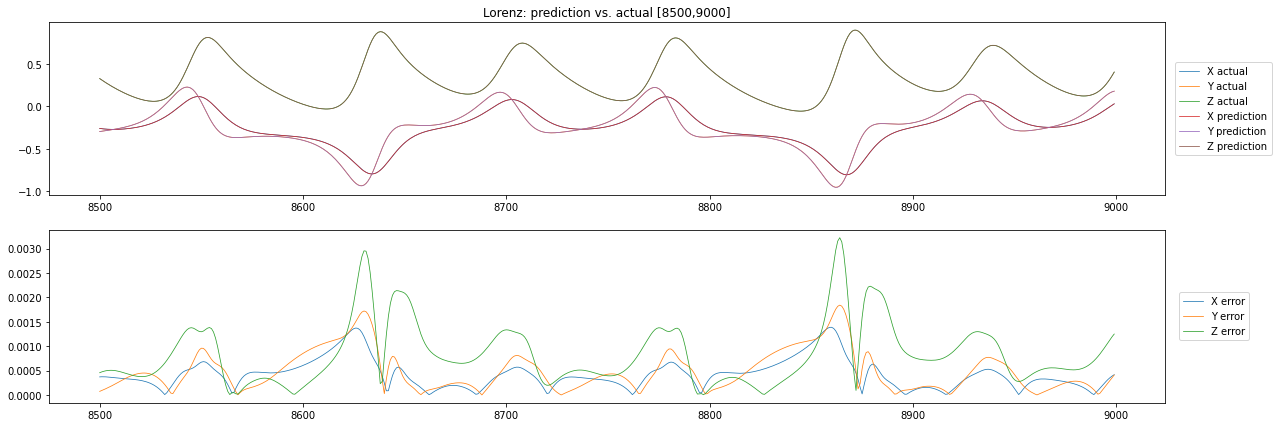

In [155]:
start = 8500
pts_to_show = 500
fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="X actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,1], linewidth=0.75, label="Y actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_target[start-test_start:start-test_start+pts_to_show,2], linewidth=0.75, label="Z actual")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,0], linewidth=0.75, label="X prediction")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,1], linewidth=0.75, label="Y prediction")
axs[0].plot(np.arange(start,start+pts_to_show), test_out[start-test_start:start-test_start+pts_to_show,2], linewidth=0.75, label="Z prediction")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,0]-test_target[start-test_start:start-test_start+pts_to_show,0]), linewidth=0.75, label="X error")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,1]-test_target[start-test_start:start-test_start+pts_to_show,1]), linewidth=0.75, label="Y error")
axs[1].plot(np.arange(start,start+pts_to_show), np.abs(test_out[start-test_start:start-test_start+pts_to_show,2]-test_target[start-test_start:start-test_start+pts_to_show,2]), linewidth=0.75, label="Z error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.08,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{start},{start+pts_to_show}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
fig.savefig(f'lorenz-one-step-lstm_eval_[{start},{start+pts_to_show}].png',facecolor='white', transparent=False)

Recursive Prediction

In [156]:
recursive_out = recursive_prediction(model=lor_lstm_eval_model, data=data[training_start:training_end], seq_len=seqs.shape[1], t_forward=test_end-test_start, quiet=True)

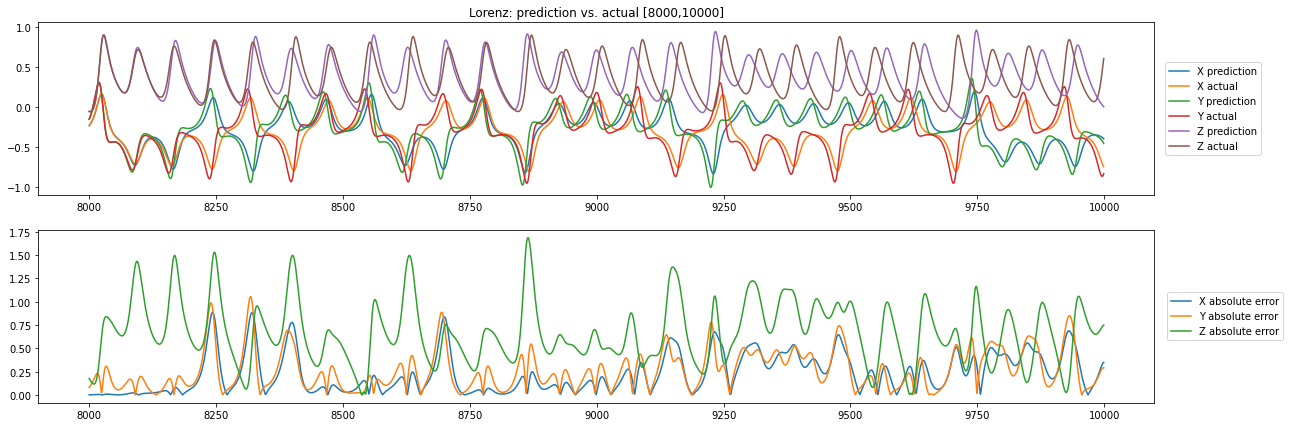

In [165]:
fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(test_start,test_end), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], label="X actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out[:,0]-test_target[:,0]), label="X absolute error")
axs[0].plot(np.arange(test_start,test_end), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], label="Y actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out[:,1]-test_target[:,0]), label="Y absolute error")
axs[0].plot(np.arange(test_start,test_end), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], label="Z actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out[:,2]-test_target[:,0]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
fig.savefig(f'lorenz-recursive_eval_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

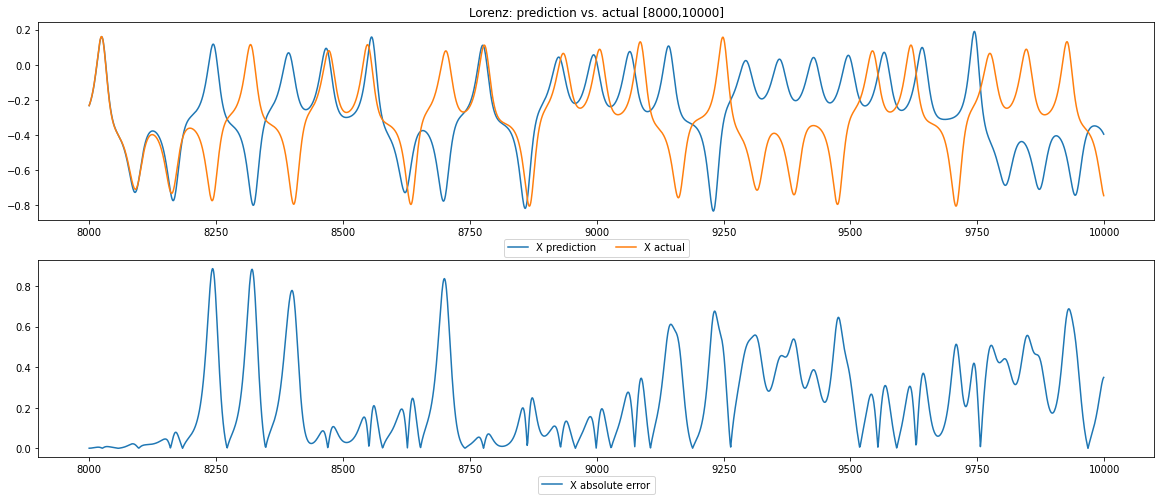

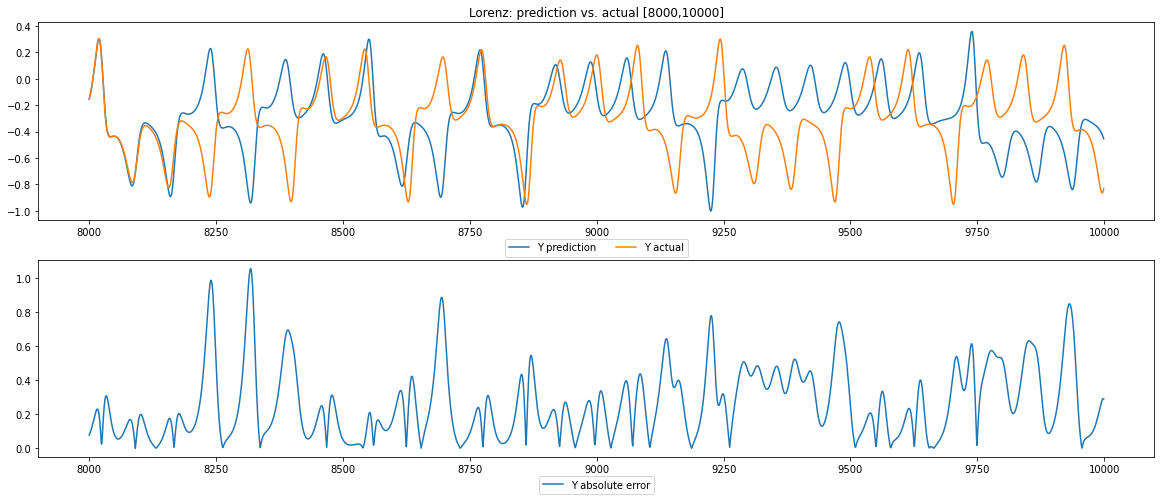

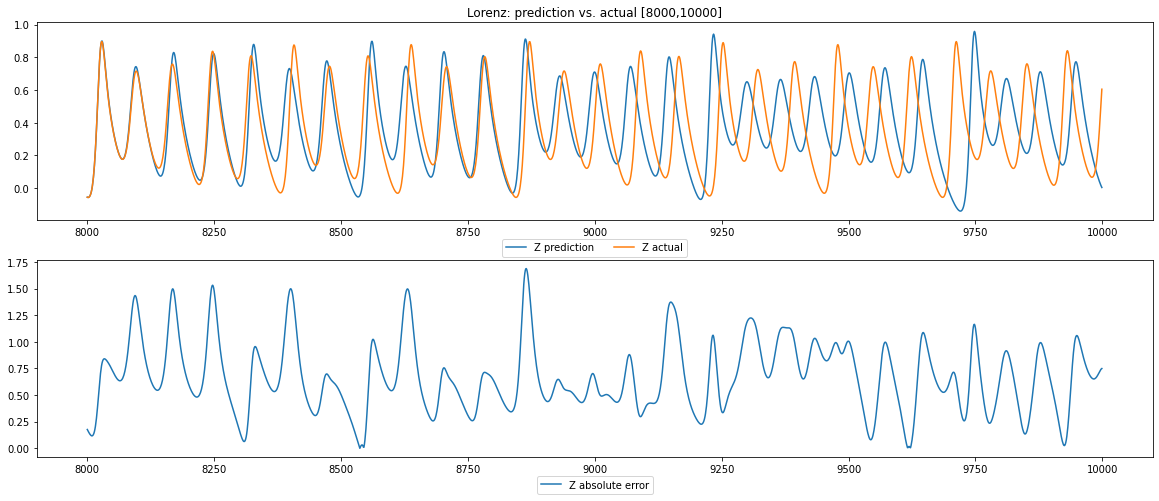

In [166]:
fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(test_start,test_end), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], label="X actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out[:,0]-test_target[:,0]), label="X absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.show()
fig.savefig(f'lorenz-recursive-X_eval_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(test_start,test_end), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], label="Y actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out[:,1]-test_target[:,0]), label="Y absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.show()
fig.savefig(f'lorenz-recursive-Y_eval_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(test_start,test_end), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], label="Z actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out[:,2]-test_target[:,0]), label="Z absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.show()
fig.savefig(f'lorenz-recursive-Z_eval_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

In [160]:
recursive_out_2 = recursive_prediction(model=lor_lstm_recursive_model, data=data[training_start:training_end], seq_len=seqs.shape[1], t_forward=test_end-test_start, quiet=True)

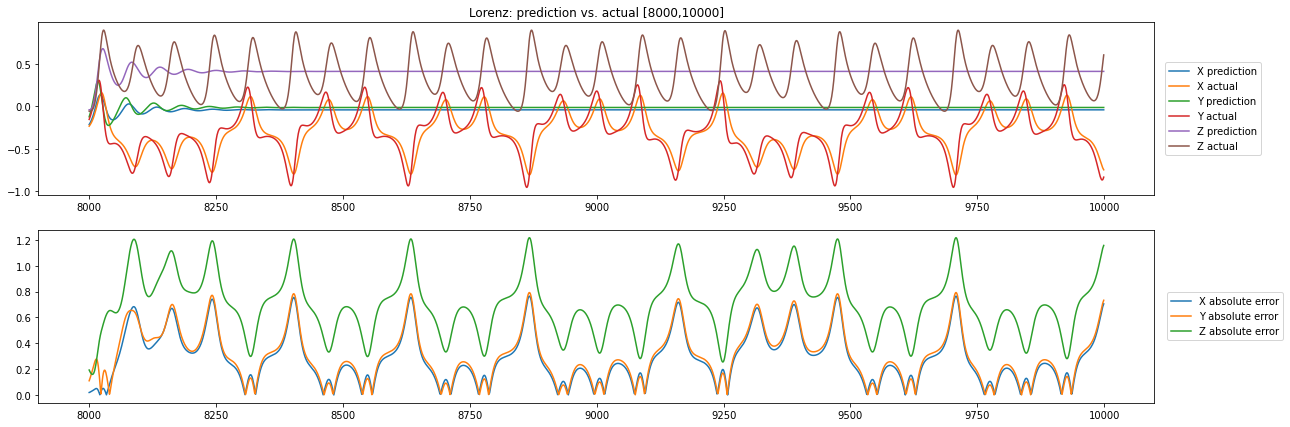

In [169]:
fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(test_start,test_end), recursive_out_2[:,0], label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], label="X actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out_2[:,0]-test_target[:,0]), label="X absolute error")
axs[0].plot(np.arange(test_start,test_end), recursive_out_2[:,1], label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], label="Y actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out_2[:,1]-test_target[:,0]), label="Y absolute error")
axs[0].plot(np.arange(test_start,test_end), recursive_out_2[:,2], label="Z prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], label="Z actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out_2[:,2]-test_target[:,0]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.subplots_adjust(hspace=0.2)
plt.show()
fig.savefig(f'lorenz-recursive_rec_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

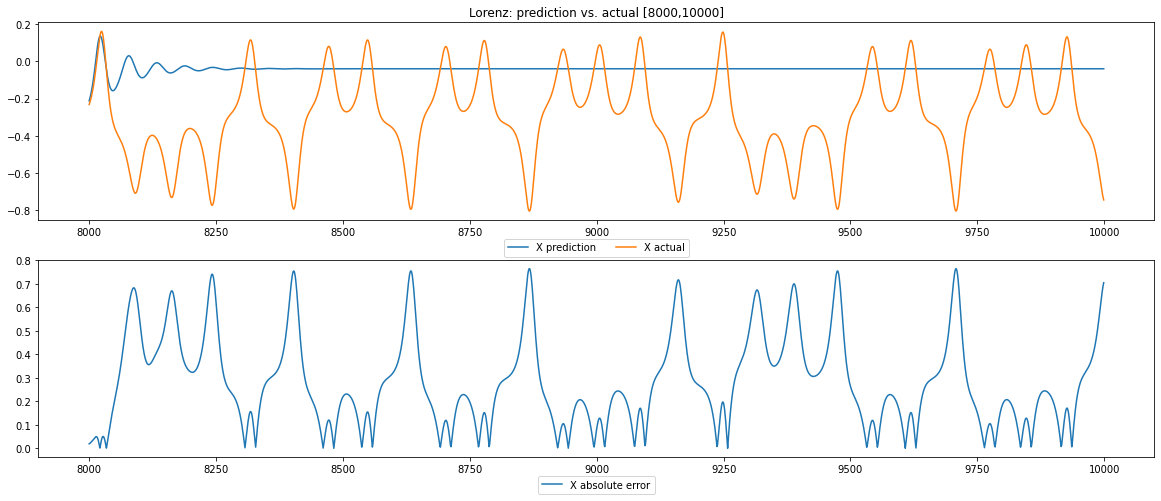

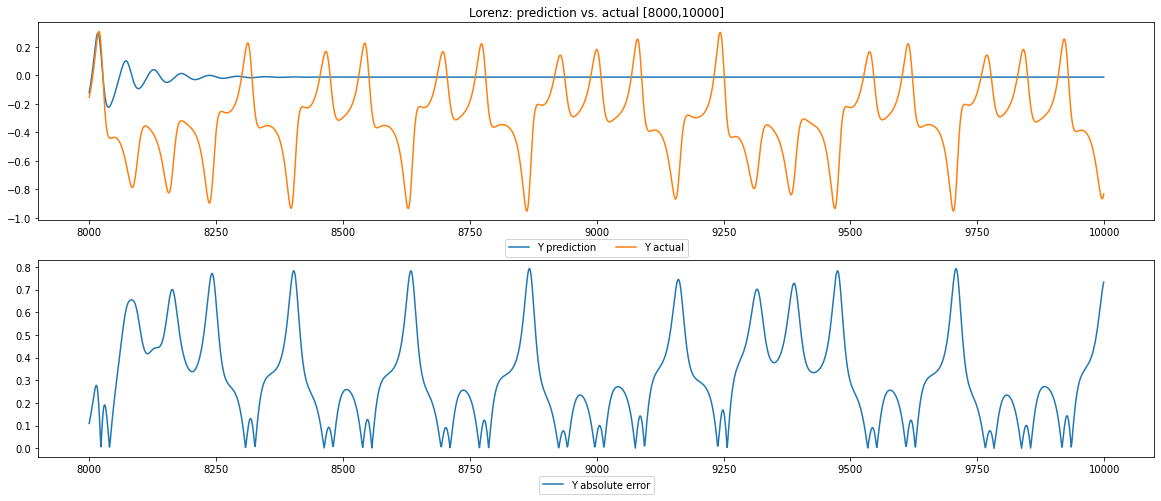

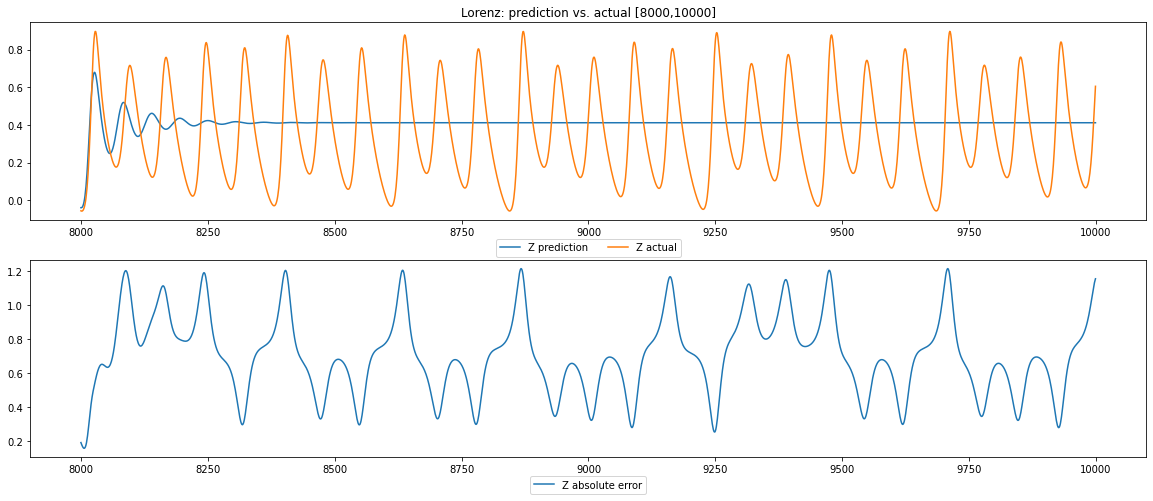

In [168]:
fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(test_start,test_end), recursive_out_2[:,0], label="X prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,0], label="X actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out_2[:,0]-test_target[:,0]), label="X absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.show()
fig.savefig(f'lorenz-recursive-X_rec_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(test_start,test_end), recursive_out_2[:,1], label="Y prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,1], label="Y actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out_2[:,1]-test_target[:,0]), label="Y absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.show()
fig.savefig(f'lorenz-recursive-Y_rec_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].plot(np.arange(test_start,test_end), recursive_out_2[:,2], label="Z prediction")
axs[0].plot(np.arange(test_start,test_end), test_target[:,2], label="Z actual")
axs[1].plot(np.arange(test_start,test_end), np.abs(recursive_out_2[:,2]-test_target[:,0]), label="Z absolute error")
axs[0].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[1].legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5,-0.21))
axs[0].set_title(f'Lorenz: prediction vs. actual [{test_start},{test_end}]')
plt.show()
fig.savefig(f'lorenz-recursive-Z_rec_lstm_[{test_start},{test_end}].png',facecolor='white', transparent=False)

In [177]:
# one-step model
lor_lstm_eval_model.evaluate(test_seqs, test_target)

63/63 [==============================] - 1s 10ms/step - loss: 7.1893e-04


0.0007189285242930055

In [163]:
RMSE(recursive_out, test_target)

0.5516036522338469

In [178]:
# recursive model
lor_lstm_recursive_model.evaluate(test_seqs, test_target)

63/63 [==============================] - 1s 10ms/step - loss: 0.0371


0.037127070128917694

In [164]:
RMSE(recursive_out_2, test_target)

0.5786048779676364

In [74]:
for i in range(len(lor_lstm_model_arr)):
    model = lor_lstm_model_arr[i]
    model.save(f'keras-models/lor-lstm-model-{i}')

INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-0/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-0/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-1/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-1/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-2/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-2/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-3/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-3/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-4/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-4/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-5/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-5/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-6/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-6/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-7/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-7/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-8/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-8/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-9/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-9/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-10/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-10/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-11/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-11/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-12/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-12/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-13/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-13/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-14/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-14/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-15/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-15/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-16/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-16/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-17/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-17/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-18/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-18/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-19/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-19/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-20/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-20/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-21/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-21/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-22/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-22/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-23/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-23/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-24/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-24/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-25/assets


INFO:tensorflow:Assets written to: keras-models/lor-lstm-model-25/assets
